# Tarea 2, pregunta 1: "RNN sobre texto"

## Integrantes

* _**Francisco Olivares - 201473575-8 - fracisco.olivars.14@sansano.usm.cl**_
* _**Felipe Vega - 201473511-1 - felipe.vega.14@sansano.usm.cl**_

In [1]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow GPU stuff :v
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# Modificar estilos de jupyter
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.text_cell_render p, .text_cell_render li { font-size: 12.5pt !important; }</style>"))
display(HTML("<style>.text_cell_render li { margin: 0 0 10px 0; }</style>"))

# Tamaño fuente matplotlib
font = {'family' : 'normal', 'weight' : 'normal', 'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

## a)

In [2]:
df_ner = pd.read_csv("./dataset_1/ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [3]:
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]

# Cantidad de lapabras a utilizar
n_used = 500000
dataX_raw, dataY_raw = [],[]
lemmas, labels = set(), set()  #uniques

initial_sentence = True
sentence= []
labels_sentence = []

for fila in dataset.values[:n_used]:
    if fila[-1]=="__START1__":
        
        
        if initial_sentence:
            initial_sentence = False
            
        else:
            dataX_raw.append(sentence)
            dataY_raw.append(labels_sentence)
            sentence= []
            labels_sentence = []
        
    lemmas.add(fila[0])
    labels.add(fila[3])
    
    sentence.append(fila[0]) #add lemma
    labels_sentence.append(fila[3]) #TAG
    
# dataX_raw = dataX_raw[1:]
# dataY_raw = dataY_raw[1:]

In [4]:
print("Cantidad de frases:", len(dataX_raw))
print("Cantidad de tags:", len(dataY_raw))


len_of_sentence = set([len(i) for i in dataX_raw])
len_of_tags = set([len(i) for i in dataY_raw])

print("Sentencia más corta: {}, más larga: {}, largos distintos: {}".format(min(len_of_sentence), max(len_of_sentence), len(len_of_sentence)))
print("Tags más corta: {}, más larga: {}, largos distintos: {}".format(min(len_of_tags), max(len_of_tags), len(len_of_tags)))

Cantidad de frases: 22901
Cantidad de tags: 22901
Sentencia más corta: 1, más larga: 70, largos distintos: 62
Tags más corta: 1, más larga: 70, largos distintos: 62


## b)
Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen las palabras en todo el dataset. **¿Se observa una ley Zipf?**[[1]](#refs) Realice un gráfico de la cantidad de datos por clase. Comente.

/home/francisco/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


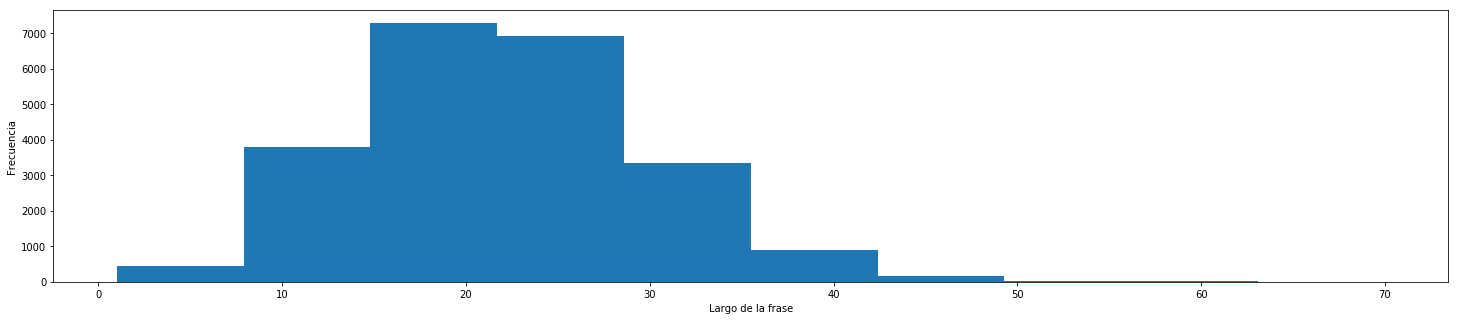

In [5]:
len_of_sentence = [len(i) for i in dataX_raw]
plt.figure(figsize = (25,5))

plt.hist(len_of_sentence)

plt.xlabel("Largo de la frase")
plt.ylabel("Frecuencia")

plt.show()

In [6]:
freq_of_words = {}

for fila in dataset.values[:]:# dataset.values[:n_used]:
    if fila[0] not in freq_of_words:
        freq_of_words[fila[0]] = 0
    freq_of_words[fila[0]]+=1
    
a = [ (freq_of_words[i], i) for i in freq_of_words]
a.sort(reverse=True)
# top_15 = a[:40]

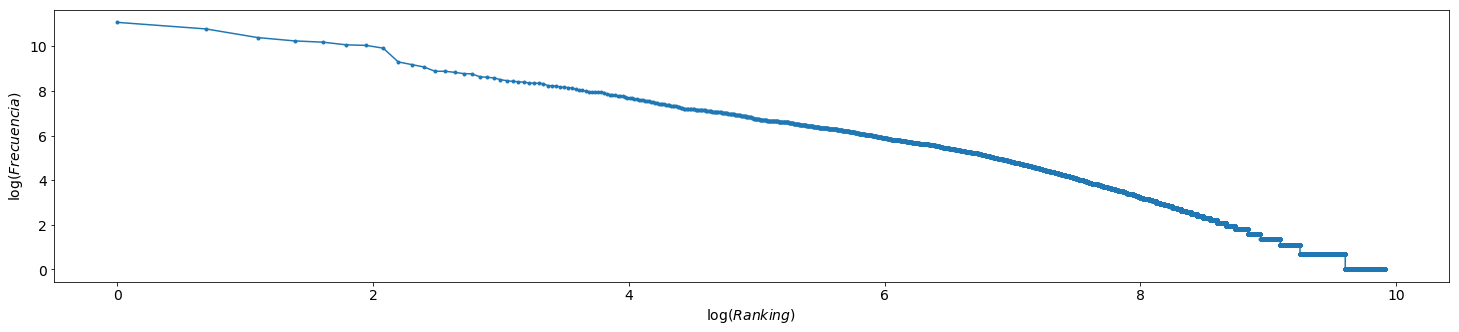

In [46]:
# Voy a transformar el arreglo top_15 para que sea graficable
X = []
Y = []

for i in range(len(a)): #range(len(top_15)):
    tupla = a[i] # top_15[i]
    Y.append( np.log(tupla[0]) )
    X.append( np.log(i+1) )

plt.figure(figsize = (25,5))

plt.plot(X, Y, '.-')

plt.xlabel("$\log(Ranking)$")
plt.ylabel("$\log(Frecuencia)$")

plt.show()

## c)
Para representar cada posible *tag* y *lemma* de modo que la red pueda manejarlo, será necesario codificarlos a un número único (*indice*) ¿Cuántos *tags* y *lemmas* distintos existen?  Comente sobre el significado del *tag* para cada *lemma*. **Finalmente mida el largo máximo de entre todas las sentencias**.

In [9]:
n_labels = len(labels)
lab2idx = {t: i for i, t in enumerate(labels)}
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY_raw] #Converting tags to indexs

n_lemmas = len(lemmas)
lemma2idx = {w: i for i, w in enumerate(lemmas)} 
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX_raw] #Converting text to indexs

In [10]:
print("Cantidad de tags distintos: ", n_labels)
print("Cantidad de lemmas distintos: ", n_lemmas)

Cantidad de tags distintos:  17
Cantidad de lemmas distintos:  12450


Hay 17 tags distintos, 12450 lemmas distintos. La sentencia más larga dentro del caso de estudio (primeras 500000 palabras) es de 70 palabras (ver pregunta **a**).

## d)
Debido a la distinta extensión de textos se deberá **realizar *padding* para estandarizar el largo**,
considere algun carácter especial **no presente en el vocabulario** para codificar el espacio en blanco en ambos (entrada y salida), por ejemplo si el largo máximo es de 4 y se tiene la sentencia "the rocket" codificada como [32,4] será necesario agregar un *lemma* que codificado significará el fin de la sentencia "the rocket *ENDPAD ENDPAD*" que codificado quedará como [32,4,*N, N*]. Decida, respecto al cómo funciona una red recurrente y su *memoria*, sobre qué le parece más conveniente al momento de rellenar con un valor especial ¿Al principio o al final de la sentencia? Comente

In [11]:
# Se le asigna el último número a los caracteres de padding
lemma2idx["END"] = n_lemmas
lab2idx["END"] = n_labels
n_labels +=1
n_lemmas +=1

from keras.preprocessing import sequence
X = sequence.pad_sequences(dataX, maxlen=max(len_of_sentence), padding='pre', value=lemma2idx["END"])
y = sequence.pad_sequences(dataY, maxlen=max(len_of_tags), padding='pre', value=lab2idx["END"])
del dataY[:],dataX[:]

Using TensorFlow backend.


Se elige utilizar pre-pading ya que en el paper *"Effects of padding on LSTMS and CNNS "* [[1]](#referencias) se muestra empiricamente que al ocupar pre padding hay un mejor desempeño.

## e)
Para poder generar una representación adecuada sobre los datos de entrada que permita realizar operaciones lineales, deberá generar una representación a un vector denso. Para ésto se utilizará la arquitectura de autoencoder **Word2Vec** sobre textos *raws* de largo variable, en donde el *encoder* codifica una palabra categórica (*target*) a un vector denso de dimensionalidad $d$ mientras que el *decoder* genera palabras en el contexto (*context*) de la palabra *target* (en una vecindad alrededor). La idea detrás es que palabras similares sean proyectadas a una región cercana en el espacio de *embedding* ¿Cuál es la importancia del parámetro min_count? ¿Cuántos *lemmas* ve Word2Vec?

In [21]:
from gensim.models import Word2Vec
EMBEDDING_DIM = 32
window_size = 5
nb_epoch = 5
batch_size = 6000
min_count = 3
model = Word2Vec(
    dataX_raw,
    size = EMBEDDING_DIM,
    window = window_size,
    batch_words = batch_size,
    iter = nb_epoch,
    min_count = min_count,
    negative = 5,
    sg = 1
) #sg=1 mean skip-gram

embeddings_index = {vocab_word: model.wv[vocab_word] for vocab_word in model.wv.vocab}
len(embeddings_index.keys())

6957

El parámetro min_count es la cantidad mínima de veces que debe aparecer la palabra en el texto para que sea tomada en consideración. Este parámetro tiene importancia ya que a mayor ocurrencia en el texto se tienen más ejemplos de contextos en los que se usa y por lo tanto se pueda aprender una tranformación más confiafle de dicha palabra a vector.

Al inicio ve todos los lemmas presentes en dataX_raw 12450, pero dada la restricción de la frecuencia mínima genera una transformación a sólo 6957.

In [25]:
# Se genera matriz de embedding
embedding_matrix = np.zeros((n_lemmas, EMBEDDING_DIM))
for word, i in lemma2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: #if word does not has embedding
        embedding_matrix[i] = embedding_vector
        
from keras.utils import to_categorical
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])

## f)
Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación **¿Cuáles son las dimensiones de entrada y salida de cada conjunto?** Comente

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

print("Entrenamiento:",X_train.shape, "Test:", X_test.shape)
print("Entrenamiento:",y_train.shape, "Test:", y_test.shape)

Entrenamiento: (16030, 70) Test: (6871, 70)
Entrenamiento: (16030, 70, 18) Test: (6871, 70, 18)


En el caso de entrada: Son 2 matrices de 16030 (Entrenamiento) y 6871 (Validación) ejemplos. Cada ejemplo tiene 70 columnas indicando las 70 posibles palabras que pertenecen a la frase.

En el caso de la salida: Son la misma cantidad de palabras para cada uno (16030 y 6871), pero ahora por cada palabra de la frase (70 palabras) hay un vector de largo 18 indicando los tags presentes en la palabra.

## g)
Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* la entidad en el texto. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *tag* a cada uno de los *lemmas*, por lo que la salida de la red es una por cada instante de tiempo que se necesita entregar un *output*. La primera capa de la red a construir debe tener los vectores de *embedding* encontrados por **Word2Vec**. **Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red**. Entrene y luego evalúe su desempeño sobre ambos conjuntos.

In [47]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout, TimeDistributed
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=70,
                    trainable=False, weights=[embedding_matrix]))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam')
history_g = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128, verbose=0)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 32)            398432    
_________________________________________________________________
lstm_2 (LSTM)                (None, 70, 100)           53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 70, 18)            1818      
Total params: 453,450
Trainable params: 55,018
Non-trainable params: 398,432
_________________________________________________________________


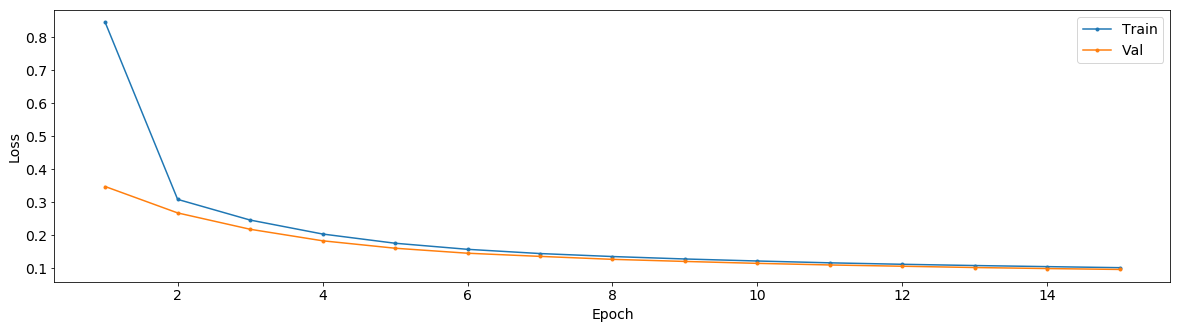

In [48]:
def chart_loss(history, epoch_number):
    epoch_arr = [i+1 for i in range(epoch_number)]
    plt.figure(figsize = (20,5))
    plt.plot(epoch_arr, history.history['loss'], '.-')
    plt.plot(epoch_arr, history.history['val_loss'], '.-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend( ('Train', 'Val') )

    plt.show()

chart_loss(history_g, 15)

# Referencias

[1](2019). Arxiv.org. Retrieved 19 July 2019, from https://arxiv.org/pdf/1903.07288.pdf